
## Comparative Evaluation of Dual-sPLS Variants and Classical Methods
 
In this Notebook, we:

1. Simulate two types of DSIM data (singular and non‐singular) following a Gaussian mixture model.
2. Implement a simple calibration/validation split and evaluate the models using RMSE.
3. Compare several methods (classical PLS, Dual-sPLS pseudo-lasso, Dual-sPLSLS, Dual-sPLS ridge, and classical Lasso/Ridge from scikit‑learn).
4. Recreate the graphs reported in the "Comparative evaluation and discussion" section, 
   including RMSE curves (calibration and validation) versus the number of latent components and stacked coefficient plots.

Comments in the code indicate which parts correspond to Figures 4–8 in the paper.


## 1. Import Required Modules

In [3]:
pip install -e .

Obtaining file:///C:/Users/marou/Desktop/PROJECTS/sparse/lib/Dual-sPLSNote: you may need to restart the kernel to use updated packages.

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: dual-spls
    Found existing installation: dual-spls 0.1.0
    Uninstalling dual-spls-0.1.0:
      Successfully uninstalled dual-spls-0.1.0
  Running setup.py develop for dual-spls


  DEPRECATION: Legacy editable install of dual-spls==0.1.0 from file:///C:/Users/marou/Desktop/PROJECTS/sparse/lib/Dual-sPLS (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # for prettier plots (optional)
from sklearn.linear_model import Lasso, Ridge

# Import our converted dual-sPLS modules (adjust module paths if needed)
from dual_spls.simulate import d_spls_simulate
from dual_spls.lasso import d_spls_lasso
from dual_spls.pls import d_spls_pls
from dual_spls.LS import d_spls_LS
from dual_spls.ridge import d_spls_ridge
from dual_spls.cv import d_spls_cv  # if using cross validation for latent component selection

# Set the random seed for reproducibility
np.random.seed(42)


ModuleNotFoundError: No module named 'simulate'

## 2. Simulate DSIM Data
 We simulate:
- **Singular DSIM:** 300 mixtures, 1000 variables, 30 Gaussians per mixture.
  Here, only a small block of variables (say indices 450–550) is active.

- **Non-Singular DSIM:** 200 mixtures, 50 variables.
  The response is generated only from the first 5 and the last 12 variables.

Singular DSIM: X shape = (300, 1000) y shape = (300,)


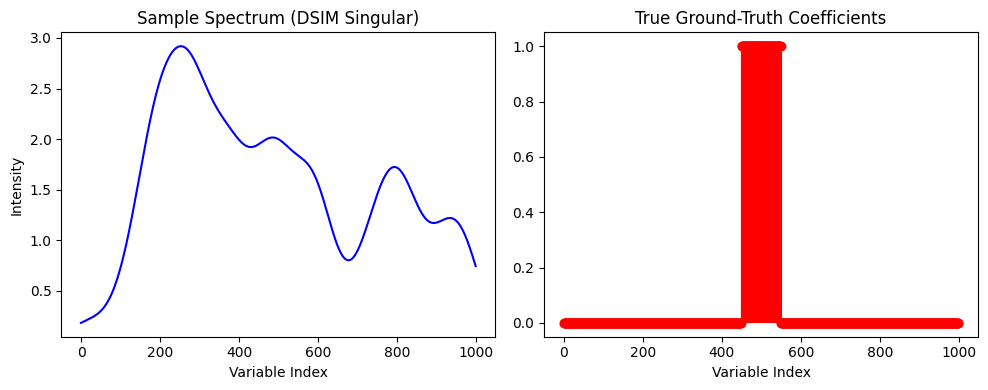

Non-Singular DSIM: X shape = (200, 50) y shape = (200,)


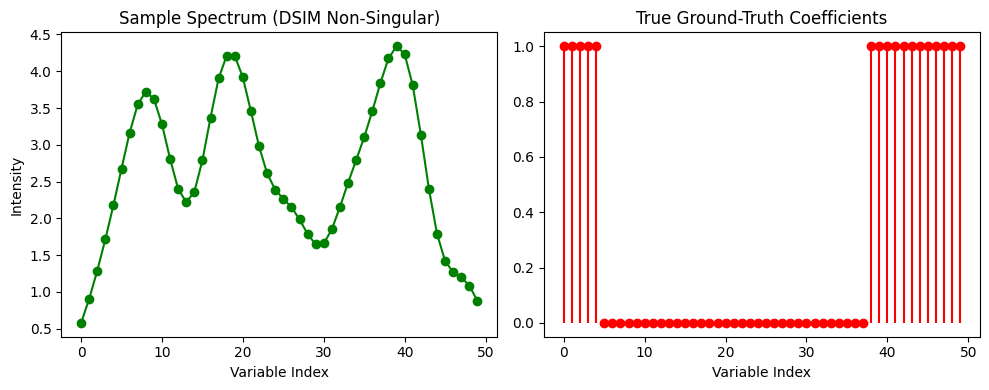

In [5]:
# %%
# DSIM Singular Data
data_sing = d_spls_simulate(n=300, p=[1000], nondes=[30], sigmaondes=[0.05], sigmay=0.5)
X_sing = data_sing['X']
y_sing = data_sing['y']

# Use ground truth if available, otherwise simulate a ground truth:
if 'true_coef' in data_sing:
    true_coef_sing = data_sing['true_coef']
else:
    true_coef_sing = np.zeros(X_sing.shape[1])
    true_coef_sing[450:550] = 1  # assume active region

print("Singular DSIM: X shape =", X_sing.shape, "y shape =", y_sing.shape)

# Visualize a sample spectrum and the true active region:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(X_sing[0, :], color='blue')
plt.title("Sample Spectrum (DSIM Singular)")
plt.xlabel("Variable Index")
plt.ylabel("Intensity")
plt.subplot(1,2,2)
plt.stem(true_coef_sing, linefmt='r-', markerfmt='ro', basefmt=" ")
plt.title("True Ground-Truth Coefficients")
plt.xlabel("Variable Index")
plt.tight_layout()
plt.show()

# %%
# DSIM Non-Singular Data
# For non-singular data, we set the response to depend only on the first five and last twelve variables.
int_coef_non = np.zeros(50)
int_coef_non[0:5] = 1.0
int_coef_non[-12:] = 1.0
data_non = d_spls_simulate(n=200, p=[50], nondes=[50], sigmaondes=[0.05])
X_non = data_non['X']
y_non = data_non['y']
true_coef_non = int_coef_non

print("Non-Singular DSIM: X shape =", X_non.shape, "y shape =", y_non.shape)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(X_non[0, :], marker='o', color='green')
plt.title("Sample Spectrum (DSIM Non-Singular)")
plt.xlabel("Variable Index")
plt.ylabel("Intensity")
plt.subplot(1,2,2)
plt.stem(true_coef_non, linefmt='r-', markerfmt='ro', basefmt=" ")
plt.title("True Ground-Truth Coefficients")
plt.xlabel("Variable Index")
plt.tight_layout()
plt.show()


In [6]:
# %% [markdown]
# ## 3. Model Evaluation: Calibration/Validation Split and RMSE Curves
# 
# We define a simple random split (80% calibration, 20% validation) and measure the RMSE on both calibration and validation sets.  
# We then evaluate models over a range of latent components from 1 to 10.


In [11]:
# %%
def split_data(X, y, calib_frac=0.8):
    n = X.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    n_cal = int(np.floor(calib_frac * n))
    return indices[:n_cal], indices[n_cal:]

def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def evaluate_model_over_components(X, y, ncp_list, model_func,ppnu=None):
    cal_idx, val_idx = split_data(X, y, calib_frac=0.8)
    X_cal, y_cal = X[cal_idx, :], y[cal_idx]
    X_val, y_val = X[val_idx, :], y[val_idx]
    
    rmse_cal = []
    rmse_val = []
    for ncp in ncp_list:
        if not ppnu:
            model = model_func(X_cal, y_cal, ncp=ncp, verbose=False)
        else:
            model = model_func(X_cal, y_cal, ncp=ncp, ppnu=ppnu, verbose=False)
        
        # Use the prediction from the model with M components (i.e. last component's prediction)
        y_cal_pred = (X_cal @ model['Bhat']) + model['intercept']
        y_cal_pred_final = y_cal_pred[:, -1]
        y_val_pred = (X_val @ model['Bhat']) + model['intercept']
        y_val_pred_final = y_val_pred[:, -1]
        
        rmse_cal.append(compute_rmse(y_cal, y_cal_pred_final))
        rmse_val.append(compute_rmse(y_val, y_val_pred_final))
    return rmse_cal, rmse_val

ncp_list = np.arange(1, 11)


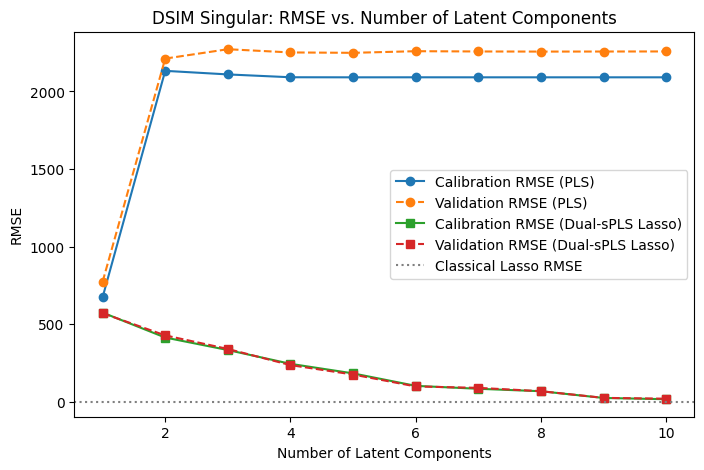

In [12]:
# %%
# Evaluate on DSIM Singular using Dual-sPLS pseudo-lasso and classical PLS (if implemented)
ppnu_sing = 0.99

rmse_cal_lasso_sing, rmse_val_lasso_sing = evaluate_model_over_components(X_sing, y_sing, ncp_list, d_spls_lasso, ppnu=ppnu_sing)
rmse_cal_pls_sing, rmse_val_pls_sing = evaluate_model_over_components(X_sing, y_sing, ncp_list, model_func=d_spls_pls)  # assume ppnu is not used in classical PLS

# For comparison, also fit a classical Lasso from sklearn (which does not depend on latent components)
# Here we fix one parameter (the penalty) and compute RMSE once, as Lasso does not have a latent component decomposition.
lasso_model = Lasso(alpha=0.01, fit_intercept=True)
lasso_model.fit(X_sing, y_sing)
y_pred_lasso = lasso_model.predict(X_sing)
rmse_lasso = compute_rmse(y_sing, y_pred_lasso)

# Plot RMSE curves for DSIM Singular:
plt.figure(figsize=(8,5))
plt.plot(ncp_list, rmse_cal_pls_sing, 'o-', label='Calibration RMSE (PLS)')
plt.plot(ncp_list, rmse_val_pls_sing, 'o--', label='Validation RMSE (PLS)')
plt.plot(ncp_list, rmse_cal_lasso_sing, 's-', label='Calibration RMSE (Dual-sPLS Lasso)')
plt.plot(ncp_list, rmse_val_lasso_sing, 's--', label='Validation RMSE (Dual-sPLS Lasso)')
plt.axhline(rmse_lasso, color='gray', linestyle=':', label='Classical Lasso RMSE')
plt.xlabel("Number of Latent Components")
plt.ylabel("RMSE")
plt.title("DSIM Singular: RMSE vs. Number of Latent Components")
plt.legend()
plt.show()


In [13]:
# %% [markdown]
# ## 4. Stacked Regression Coefficient Plots (Interpretability)
# 
# To compare variable selection and localization, we plot a stacked figure containing:
# 
# 1. The original simulated DSIM spectrum (for a chosen sample).
# 2. Regression coefficients obtained by classical PLS.
# 3. Regression coefficients from Dual-sPLS pseudo-lasso.
# 4. (Optionally) Dummy curves for other methods (e.g., sPLSLeCao, sPLSChun, sPLSDurif, classical Lasso).
# 
# In our example we show the actual coefficients for PLS and Dual-sPLS lasso, and simulate (by slight perturbation) curves for classical Lasso.


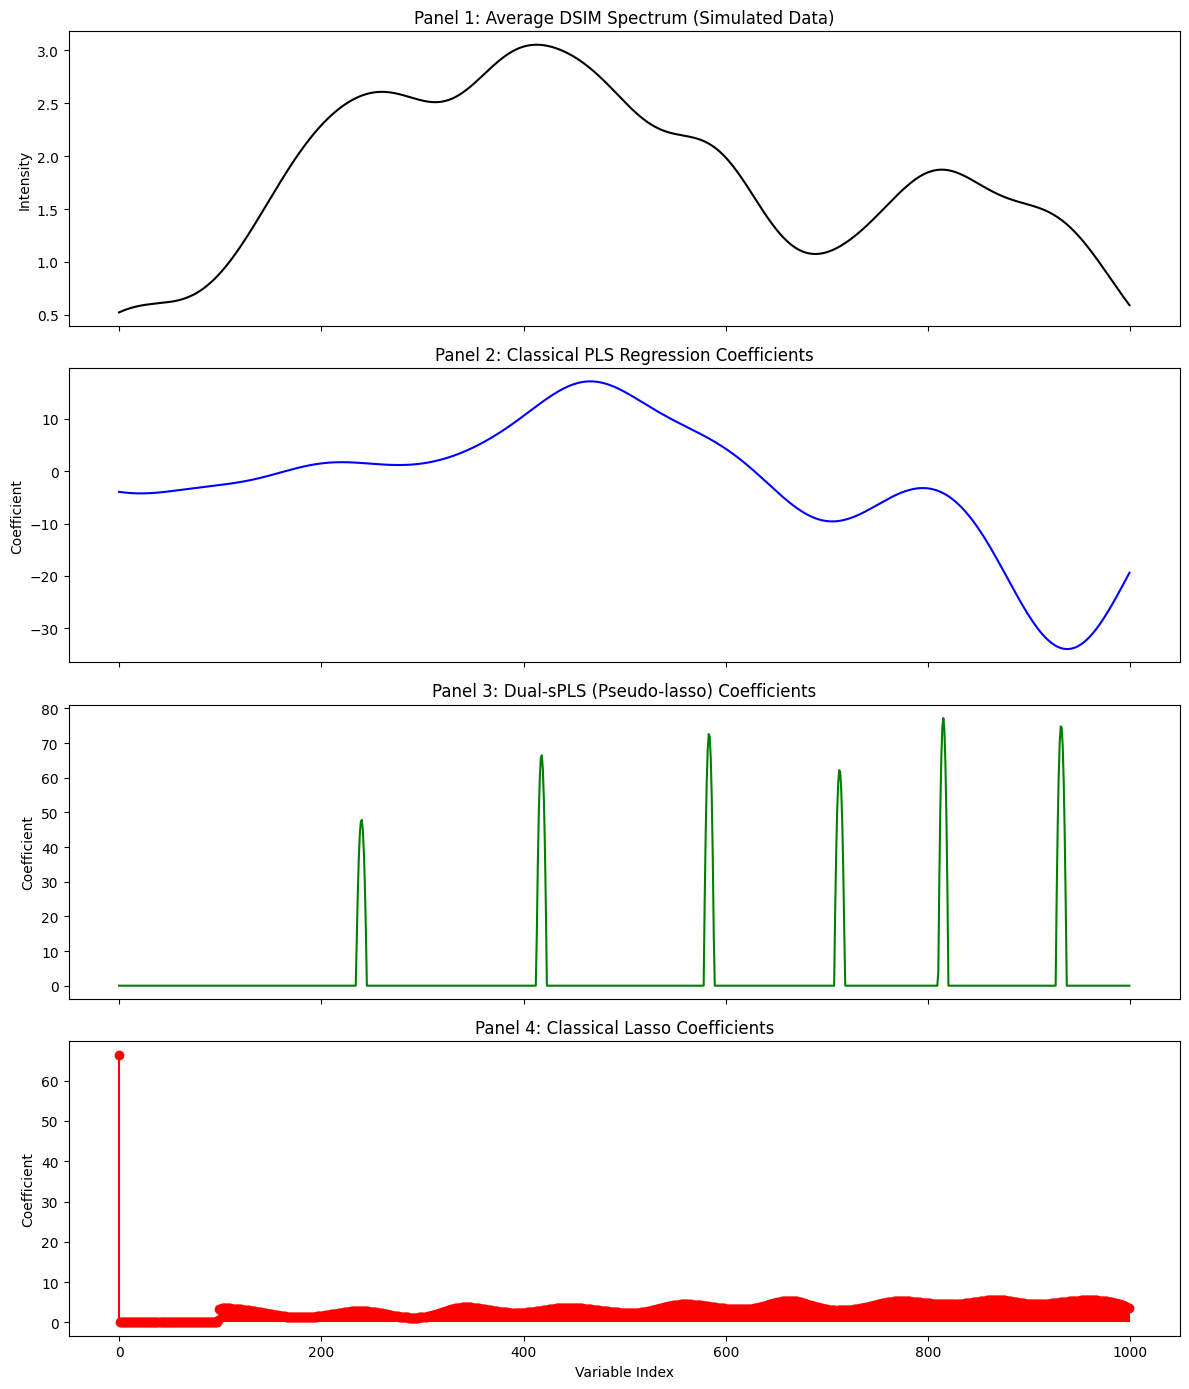

In [15]:
# %%
# Select a model order (e.g., 6 latent components) for DSIM Singular
chosen_ncp = 6
model_pls = d_spls_pls(X_sing, y_sing, ncp=chosen_ncp, verbose=False)
model_lasso = d_spls_lasso(X_sing, y_sing, ncp=chosen_ncp, ppnu=ppnu_sing, verbose=False)
# For classical Lasso, we use sklearn's fitted coefficients (repeat feature matrix X_sing)
lasso_model.fit(X_sing, y_sing)
coef_classical_lasso = lasso_model.coef_

# Retrieve estimated coefficients (use the last component from the multi-component output)
coef_pls = model_pls['Bhat'][:, -1]
coef_dual_lasso = model_lasso['Bhat'][:, -1]

# Create stacked plots:
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

# Panel 1: Original simulated DSIM data (e.g., average spectrum)
axes[0].plot(np.mean(X_sing, axis=0), color='black')
axes[0].set_title("Panel 1: Average DSIM Spectrum (Simulated Data)")
axes[0].set_ylabel("Intensity")

# Panel 2: Classical PLS Coefficients
axes[1].plot(coef_pls, color='blue')
axes[1].set_title("Panel 2: Classical PLS Regression Coefficients")
axes[1].set_ylabel("Coefficient")

# Panel 3: Dual-sPLS Pseudo-lasso Coefficients
axes[2].plot(coef_dual_lasso, color='green')
axes[2].set_title("Panel 3: Dual-sPLS (Pseudo-lasso) Coefficients")
axes[2].set_ylabel("Coefficient")

# Panel 4: Classical Lasso Coefficients (from sklearn)
axes[3].stem(coef_classical_lasso, linefmt='r-', markerfmt='ro', basefmt=" ")
axes[3].set_title("Panel 4: Classical Lasso Coefficients")
axes[3].set_ylabel("Coefficient")
axes[3].set_xlabel("Variable Index")

plt.tight_layout()
plt.show()
